In [1]:
import pandas as pd
import numpy as np
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split, KFold
from sklearn.metrics import accuracy_score, brier_score_loss

%matplotlib inline

from collections import Counter
sns.set(style='white', context='notebook', palette='deep')

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv("adult.csv")
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [3]:
dataset.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

In [4]:
dataset.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


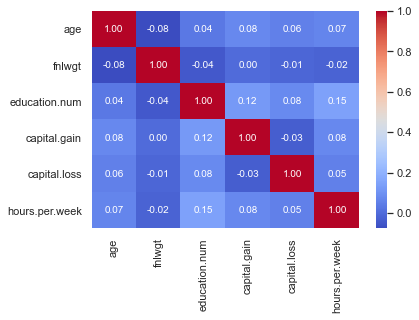

In [5]:
numeric_features = ['age','fnlwgt','education.num','capital.gain','capital.loss','hours.per.week','income']
cat_features = ['workclass','education','marital.status', 'occupation', 'relationship', 'race', 'sex', 'native']
    
sns.heatmap(dataset[numeric_features].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

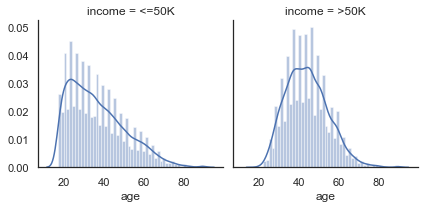

In [7]:
g = sns.FacetGrid(dataset, col='income')
g.map(sns.distplot, "age")

In [9]:
def clean_dataset(df):
    df['income']=df['income'].map({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})
    df["workclass"] = df["workclass"].fillna("X")
    df["occupation"] = df["occupation"].fillna("X")
    df["native.country"] = df["native.country"].fillna("United-States")
    df["sex"] = df["sex"].map({"Male": 0, "Female":1})
    df["marital.status"] = df["marital.status"].replace(['Never-married','Divorced','Separated','Widowed'], 'Single')
    df["marital.status"] = df["marital.status"].replace(['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse'], 'Married')
    df["marital.status"] = df["marital.status"].map({"Married":1, "Single":0})
    df["marital.status"] = df["marital.status"].astype(int)
    df.drop(labels=["workclass","education","occupation","relationship","race","native.country"], axis = 1, inplace = True)
    return df

In [11]:
dataset = clean_dataset(dataset)
dataset.tail()

,age,fnlwgt,education.num,marital.status,sex,capital.gain,capital.loss,hours.per.week,income
32556,22,310152,10,0,0,0,0,40,0
32557,27,257302,12,1,1,0,0,38,0
32558,40,154374,9,1,0,0,0,40,1
32559,58,151910,9,0,1,0,0,40,0
32560,22,201490,9,0,0,0,0,20,0


In [139]:
array = dataset.values
X = array[:,0:8]
Y = array[:,8]
validation_size = 0.20
seed = 7
scoring = 'accuracy'
X_train, X_validation, Y_train, Y_validation = train_test_split(X,Y,
    test_size=validation_size,random_state=seed)

In [205]:
def plot_calibration_curve(array_probas, array_true_label, num_bins=5):

    ## Prepare Array
    array_probas=(array_probas - array_probas.min()) / (array_probas.max() - array_probas.min())
    df_probas = pd.DataFrame({'probas': array_probas, 'label': array_true_label})
    df_probas['bins'] = pd.cut(df_probas.probas, num_bins, labels=np.arange(num_bins))
    bined_plot = df_probas.groupby('bins').mean()

    ## Calculate Brier Score
    brier_plot = brier_score_loss(array_true_label, array_probas)
    
    ## Calculate ECE
    ece, _ = calculate_ece(array_probas, array_true_label, num_bins)
    
    ## Plot Calibration Curve
    plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    ax1.plot(bined_plot['probas'], bined_plot['label'], "s-", label="Reliability Plot")
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_title('Calibration plots  (reliability curve)')
    
    bbox_props = dict(boxstyle="round", fc="lightgrey", ec="brown", lw=2)
    ax1.text(0.1, 0.9, "Brier Score: {:.4f}".format(brier_plot), ha="center", va="center", size=14, weight = 'bold', bbox=bbox_props)
    ax1.text(0.1, 0.8, "ECE: {:.4f}".format(ece), ha="center", va="center", size=14, weight = 'bold', bbox=bbox_props)

    ax2.hist(df_probas['probas'], range=(0, 1), bins=num_bins, histtype="step", lw=2)
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax1.grid()
    ax2.grid()
    plt.tight_layout()
    plt.show()

In [206]:
def plot_compare_calibration(array_probas, array_probas_calibrated, array_true_label, num_bins=5):

    ## Prepare Array
    array_probas=(array_probas - array_probas.min()) / (array_probas.max() - array_probas.min())
    array_probas_calibrated =(array_probas_calibrated - array_probas_calibrated.min()) / (array_probas_calibrated.max() - array_probas_calibrated.min())
    
    df_probas = pd.DataFrame({'probas': array_probas, 
                              'calibrated':array_probas_calibrated,
                              'label': array_true_label})
    df_probas['bins'] = pd.cut(df_probas.probas, num_bins, labels=np.arange(num_bins))
    bined_plot = df_probas.groupby('bins').mean()

    ## Calculate Brier Score
    brier_plot_prior = brier_score_loss(array_true_label, array_probas)
    brier_plot_calib = brier_score_loss(array_true_label, array_probas_calibrated)
    
    ## Calculate ECE
    ece_prior, _ = calculate_ece(array_probas, array_true_label, num_bins)
    ece_calib, _ = calculate_ece(array_probas_calibrated, array_true_label, num_bins)
    
    ## Plot Calibration Curve
    plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    ax1.plot(bined_plot['probas'], bined_plot['label'], color='green', linestyle='dashed', label="Reliability Plot")
    ax1.plot(bined_plot['calibrated'], bined_plot['label'], color='orange', linestyle='solid', label="Reliability Plot")
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_title('Calibration plots  (reliability curve)')
    
    ax1.text(0.1, 0.9, "Brier Score: {:.4f}".format(brier_plot_prior), size=14, bbox={'boxstyle': 'round', 'fc': 'lightgrey', 'ec': 'green', 'lw': 2})
    ax1.text(0.1, 0.8, "ECE Score: {:.4f}".format(ece_prior), size=14, bbox={'boxstyle': 'round', 'fc': 'lightgrey', 'ec': 'green', 'lw': 2})
    ax1.text(0.1, 0.7, "Brier Score Calibrated: {:.4f}".format(brier_plot_calib), size=14, bbox={'boxstyle': 'round', 'fc': 'lightgrey', 'ec': 'orange', 'lw': 2})
    ax1.text(0.1, 0.6, "ECE Calibrated: {:.4f}".format(ece_calib), size=14, bbox={'boxstyle': 'round', 'fc': 'lightgrey', 'ec': 'orange', 'lw': 2})

    ax1.grid()
    plt.tight_layout()
    plt.show()

## Models

In [207]:
rf = RandomForestClassifier(n_estimators=10,max_features=5)
rf.fit(X_train, Y_train)
preds_proba_rf = rf.predict_proba(X_validation)
preds_rf = rf.predict(X_validation)
accuracy_score(Y_validation, preds_rf)

0.8389375095961922

In [208]:
ab = AdaBoostClassifier(n_estimators=10)
ab.fit(X_train, Y_train)
preds_proba_ab = ab.predict_proba(X_validation)
preds_ab = ab.predict(X_validation)
accuracy_score(Y_validation, preds_ab)

0.8432366037156457

In [257]:
hidden_size = 100
nn=MLPClassifier(hidden_layer_sizes=(hidden_size, ), 
                 activation='logistic', 
                 solver='sgd')
nn.fit(X_train, Y_train)
preds_proba_nn = nn.predict_proba(X_validation)
preds_nn = nn.predict(X_validation)
accuracy_score(Y_validation, preds_nn)

0.7666206049439582

## Expected Calibration Error

**Expected Calibration Error** $\rightarrow$ partition prediction into *M* bins, and take weighted average of the bins accuracy/confidence difference:


$$
\mathbb{E}_{\hat{P}}[| \mathbb{P}(\hat{Y}=Y \;|\;\hat{P}=P) -\textit{p} |]
$$

$$
ECE = \sum_{m=1}^{M} \frac{|B_{m}|}{n} |acc(B_{m})-conf(B_{m})|
$$


## Maximum Calibration Error (for High Risk applications)

**Maximum Calibration Error** $\rightarrow$ we may wish to minimize the worst-case
deviation between confidence and accuracy:

$$
max_{p\in[0,1]} \;| \mathbb{P}(\hat{Y}=Y \;|\;\hat{P}=P) -\textit{p} |
$$

$$
MCE = max_{m\in\{1,...,M\}} \;|acc(B_{m})-conf(B_{m})|
$$

In [258]:
def calculate_ece(array_probas, array_true_label, num_bins=10):
    array_probas=(array_probas - array_probas.min()) / (array_probas.max() - array_probas.min())
    df_probas = pd.DataFrame({'probas': array_probas, 'label': array_true_label})
    df_probas['bins'] = pd.cut(df_probas.probas, num_bins, labels=np.arange(num_bins))
    df_probas['bins_count']=df_probas['bins']
    bined_plot = df_probas.groupby('bins')\
        .agg({'probas':'mean', 'label':'mean', 'bins_count':'size'})\
        .rename(columns={'bins_count':'count'})\
        .reset_index()
    ece = ((bined_plot['probas']-bined_plot['label']).abs()/bined_plot['count']).sum()
    return ece, bined_plot

In [259]:
def calculate_mce(array_probas, array_true_label, num_bins=10):
    array_probas=(array_probas - array_probas.min()) / (array_probas.max() - array_probas.min())
    df_probas = pd.DataFrame({'probas': array_probas, 'label': array_true_label})
    df_probas['bins'] = pd.cut(df_probas.probas, num_bins, labels=np.arange(num_bins))
    df_probas['bins_count']=df_probas['bins']
    bined_plot = df_probas.groupby('bins')\
        .agg({'probas':'mean', 'label':'mean', 'bins_count':'size'})\
        .rename(columns={'bins_count':'count'})\
        .reset_index()
    mce = (bined_plot['probas']-bined_plot['label']).abs().max()
    return mce, bined_plot

In [260]:
calculate_ece(preds_proba_rf[:,1], Y_validation)

(0.004946286387011239,   bins    probas     label  count
 0    0  0.017513  0.058778   3862
 1    1  0.200000  0.222989    435
 2    2  0.300000  0.336735    392
 3    3  0.399315  0.364486    321
 4    4  0.499664  0.385650    223
 5    5  0.598604  0.481982    222
 6    6  0.698881  0.585714    210
 7    7  0.799262  0.546875    192
 8    8  0.899259  0.600000    180
 9    9  1.000000  0.939076    476)

In [261]:
calculate_mce(preds_proba_rf[:,1], Y_validation)

(0.29925925925926233,   bins    probas     label  count
 0    0  0.017513  0.058778   3862
 1    1  0.200000  0.222989    435
 2    2  0.300000  0.336735    392
 3    3  0.399315  0.364486    321
 4    4  0.499664  0.385650    223
 5    5  0.598604  0.481982    222
 6    6  0.698881  0.585714    210
 7    7  0.799262  0.546875    192
 8    8  0.899259  0.600000    180
 9    9  1.000000  0.939076    476)

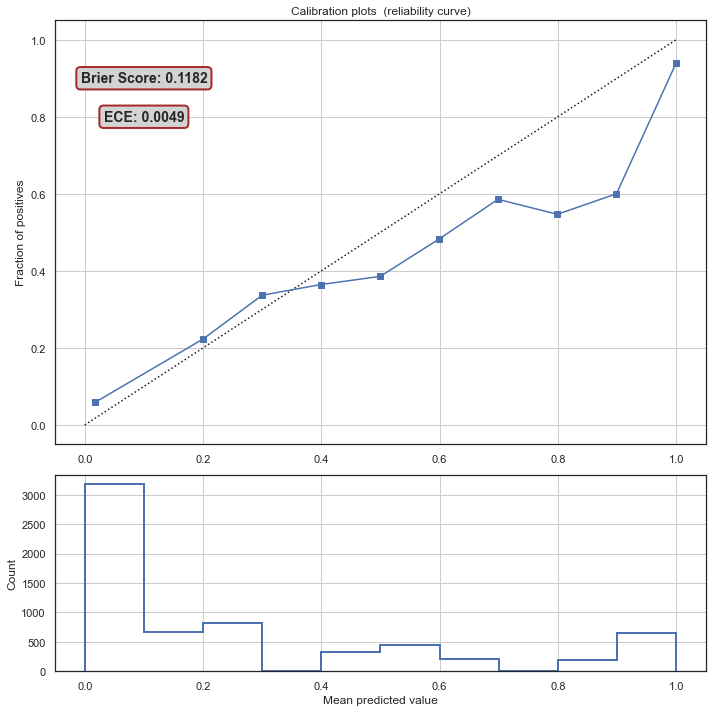

In [262]:
plot_calibration_curve(preds_proba_rf[:,1], 
                        Y_validation, 
                        num_bins=10)

In [263]:
calculate_ece(preds_proba_ab[:,1], Y_validation)

(0.003978633628949954,   bins    probas     label  count
 0    0  0.060143  0.001890    529
 1    1  0.157679  0.003125    640
 2    2  0.249919  0.018764    906
 3    3  0.341423  0.076240   1351
 4    4  0.443340  0.204469    895
 5    5  0.529537  0.396648   1253
 6    6  0.638180  0.682709    561
 7    7  0.751189  0.865169     89
 8    8  0.834455  0.983607    122
 9    9  0.957265  0.994012    167)

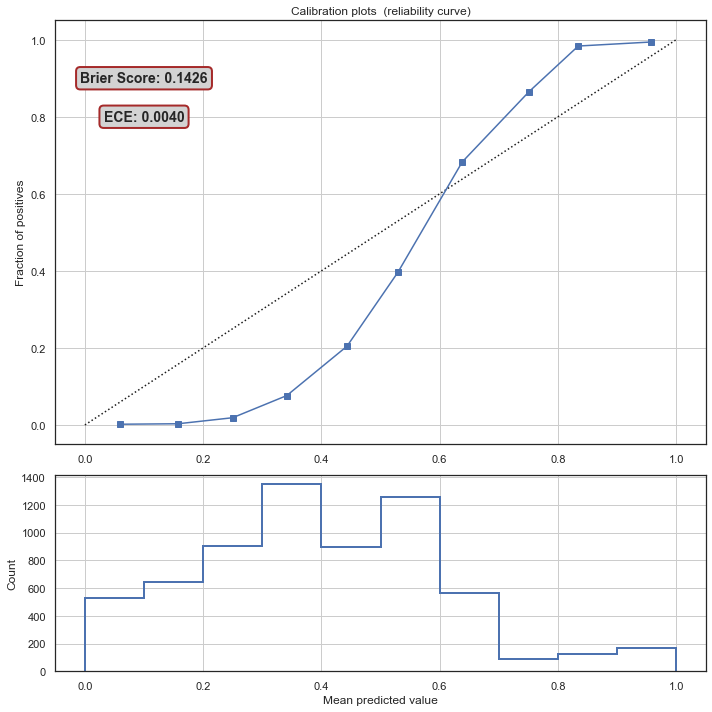

In [264]:
plot_calibration_curve(preds_proba_ab[:,1], 
                        Y_validation, 
                        num_bins=10)

In [265]:
calculate_ece(preds_proba_nn[:,1], Y_validation)

(0.9849293093175114,   bins        probas     label  count
 0    0  7.828647e-16  0.231972   6462
 1    1  1.262756e-01  0.941176     17
 2    2  2.350849e-01  1.000000      3
 3    3  3.823269e-01  1.000000      2
 4    4           NaN       NaN      0
 5    5           NaN       NaN      0
 6    6  6.580299e-01  1.000000     16
 7    7  7.825995e-01  1.000000      1
 8    8  8.735537e-01  1.000000      1
 9    9  9.127708e-01  1.000000     11)

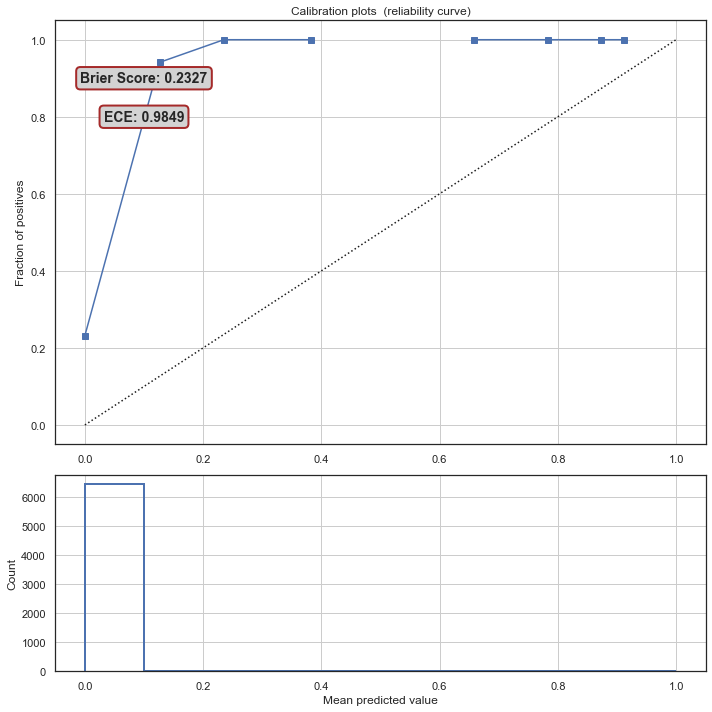

In [266]:
plot_calibration_curve(preds_proba_nn[:,1], 
                        Y_validation, 
                        num_bins=10)

## Isotonic Regression to Calibrate Preds

In [267]:
def generate_calibrated_isotonic(uncalibrated_preds, true_label):
    xtrain = uncalibrated_preds
    ytrain = true_label
    
    ## Calibrate Models
    isotonic_model = IsotonicRegression()
    isotonic_model.fit(xtrain,ytrain)
    
    calibrated_preds = isotonic_model.predict(uncalibrated_preds)

    return calibrated_preds

In [268]:
calibrated_probs_rf = generate_calibrated_isotonic(preds_proba_rf[:,1], Y_validation)
calibrated_probs_rf

array([0.04267336, 0.04267336, 0.22298851, ..., 0.22298851, 0.3625    ,
       0.93907563])

#### Calibrate Random Forest w/ Isotonic Regression

In [269]:
from sklearn.calibration import CalibratedClassifierCV

In [270]:
## Random Forest w/ Plat Scalling
clf_rf_platt = CalibratedClassifierCV(rf, cv=2, method='sigmoid')
clf_rf_platt.fit(X_train, Y_train)
prob_rf_platt = clf_rf_platt.predict_proba(X_validation)[:, 1]
prob_rf_platt

array([0.06550309, 0.08280205, 0.08305065, ..., 0.06550309, 0.52954953,
       0.87944346])

In [271]:
calculate_mce(preds_proba_rf[:,1],Y_validation), calculate_mce(prob_rf_platt,Y_validation)

((0.29925925925926233,   bins    probas     label  count
  0    0  0.017513  0.058778   3862
  1    1  0.200000  0.222989    435
  2    2  0.300000  0.336735    392
  3    3  0.399315  0.364486    321
  4    4  0.499664  0.385650    223
  5    5  0.598604  0.481982    222
  6    6  0.698881  0.585714    210
  7    7  0.799262  0.546875    192
  8    8  0.899259  0.600000    180
  9    9  1.000000  0.939076    476),
 (0.15063856168842005,   bins    probas     label  count
  0    0  0.015710  0.053641   3859
  1    1  0.144068  0.254438    507
  2    2  0.238040  0.310526    380
  3    3  0.340467  0.380952    336
  4    4  0.439343  0.420091    219
  5    5  0.535565  0.488550    262
  6    6  0.645409  0.552632    152
  7    7  0.739527  0.588889    180
  8    8  0.847461  0.725490    153
  9    9  0.984401  0.959140    465))

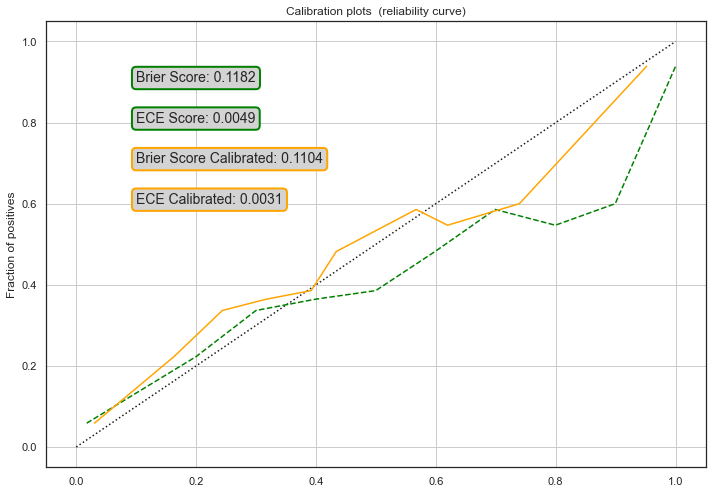

In [272]:
plot_compare_calibration(preds_proba_rf[:,1],
                         prob_rf_platt,
                         Y_validation,
                         num_bins=10)

In [273]:
## Random Forest w/ Isotonic Regression
clf_rf_isotonic = CalibratedClassifierCV(rf, cv=2, method='isotonic')
clf_rf_isotonic.fit(X_train, Y_train)
prob_rf_isotonic = clf_rf_isotonic.predict_proba(X_validation)[:, 1]
prob_rf_isotonic

array([0.03799391, 0.09709995, 0.22819146, ..., 0.03799391, 0.3729896 ,
       0.93097092])

In [274]:
calculate_mce(preds_proba_rf[:,1],Y_validation), calculate_mce(prob_rf_isotonic,Y_validation)

((0.29925925925926233,   bins    probas     label  count
  0    0  0.017513  0.058778   3862
  1    1  0.200000  0.222989    435
  2    2  0.300000  0.336735    392
  3    3  0.399315  0.364486    321
  4    4  0.499664  0.385650    223
  5    5  0.598604  0.481982    222
  6    6  0.698881  0.585714    210
  7    7  0.799262  0.546875    192
  8    8  0.899259  0.600000    180
  9    9  1.000000  0.939076    476),
 (0.10983138828701788,   bins    probas     label  count
  0    0  0.013898  0.028911   3113
  1    1  0.136946  0.153226    744
  2    2  0.247324  0.252212    678
  3    3  0.349374  0.346693    499
  4    4  0.442622  0.446953    443
  5    5  0.546688  0.595395    304
  6    6  0.644514  0.640719    167
  7    7  0.753060  0.711111    135
  8    8  0.833831  0.943662     71
  9    9  0.992013  0.980501    359))

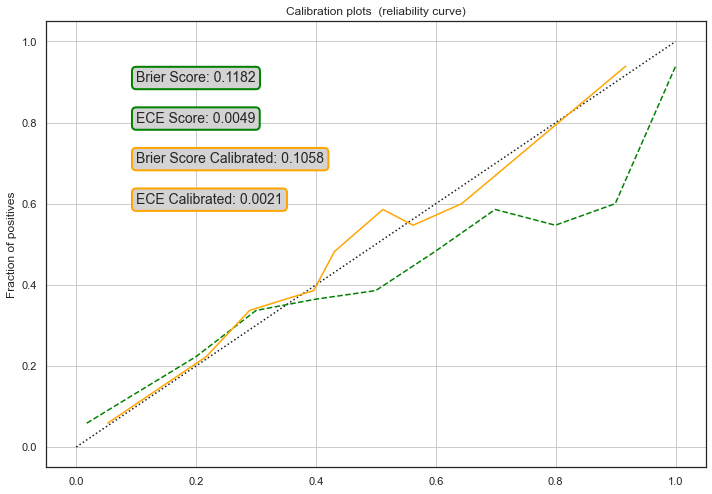

In [275]:
plot_compare_calibration(preds_proba_rf[:,1],
                         prob_rf_isotonic,
                         Y_validation,
                         num_bins=10)

In [276]:
## AdaBoost w/ Plat Scalling
clf_ab_platt = CalibratedClassifierCV(ab, cv=2, method='sigmoid')
clf_ab_platt.fit(X_train, Y_train)
prob_ab_platt = clf_ab_platt.predict_proba(X_validation)[:, 1]
prob_ab_platt

array([0.00618094, 0.01208472, 0.16576455, ..., 0.07412375, 0.33901674,
       0.99357858])

In [277]:
calculate_mce(preds_proba_ab[:,1],Y_validation), calculate_mce(prob_ab_platt,Y_validation)

((0.2651827363399474,   bins    probas     label  count
  0    0  0.060143  0.001890    529
  1    1  0.157679  0.003125    640
  2    2  0.249919  0.018764    906
  3    3  0.341423  0.076240   1351
  4    4  0.443340  0.204469    895
  5    5  0.529537  0.396648   1253
  6    6  0.638180  0.682709    561
  7    7  0.751189  0.865169     89
  8    8  0.834455  0.983607    122
  9    9  0.957265  0.994012    167),
 (0.1413956750860328,   bins    probas     label  count
  0    0  0.031269  0.028314   3214
  1    1  0.154036  0.170909    825
  2    2  0.248488  0.269912    226
  3    3  0.336621  0.334232    742
  4    4  0.470649  0.448473    524
  5    5  0.572890  0.714286     70
  6    6  0.641115  0.673307    251
  7    7  0.761810  0.669145    269
  8    8  0.850941  0.777778     54
  9    9  0.972922  0.982249    338))

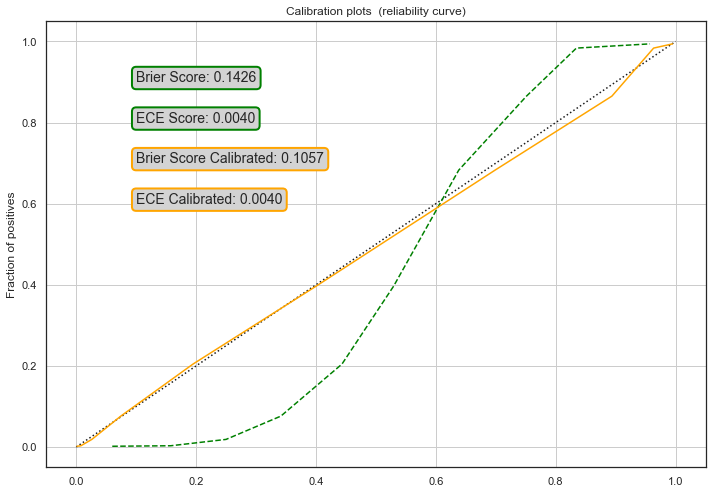

In [278]:
plot_compare_calibration(preds_proba_ab[:,1],
                         prob_ab_platt,
                         Y_validation,
                         num_bins=10)

In [279]:
## AdaBoost w/ Isotonic Regression
clf_ab_isotonic = CalibratedClassifierCV(ab, cv=2, method='isotonic')
clf_ab_isotonic.fit(X_train, Y_train)
prob_ab_isotonic = clf_ab_isotonic.predict_proba(X_validation)[:, 1]
prob_ab_isotonic

array([0.00268199, 0.00566857, 0.1702144 , ..., 0.11857375, 0.36642495,
       0.99392399])

In [280]:
calculate_mce(preds_proba_ab[:,1],Y_validation), calculate_mce(prob_ab_isotonic,Y_validation)

((0.2651827363399474,   bins    probas     label  count
  0    0  0.060143  0.001890    529
  1    1  0.157679  0.003125    640
  2    2  0.249919  0.018764    906
  3    3  0.341423  0.076240   1351
  4    4  0.443340  0.204469    895
  5    5  0.529537  0.396648   1253
  6    6  0.638180  0.682709    561
  7    7  0.751189  0.865169     89
  8    8  0.834455  0.983607    122
  9    9  0.957265  0.994012    167),
 (0.09139821442846507,   bins    probas     label  count
  0    0  0.026577  0.027371   3142
  1    1  0.155742  0.162073    907
  2    2  0.271430  0.231884    276
  3    3  0.365042  0.353870    633
  4    4  0.441806  0.445230    566
  5    5  0.561510  0.609375     64
  6    6  0.642610  0.685897    312
  7    7  0.748439  0.674208    221
  8    8  0.866908  0.775510     49
  9    9  0.982623  0.979592    343))

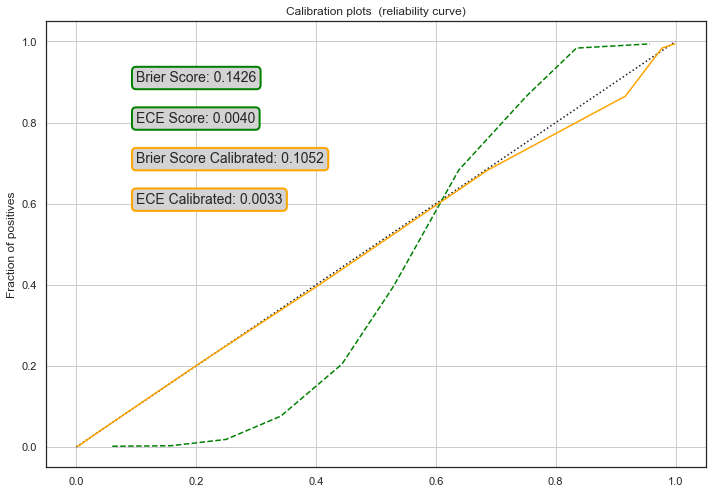

In [281]:
plot_compare_calibration(preds_proba_ab[:,1],
                         prob_ab_isotonic,
                         Y_validation,
                         num_bins=10)

In [282]:
## NN w/ Plat Scalling
clf_nn_platt = CalibratedClassifierCV(nn, cv=2, method='sigmoid')
clf_nn_platt.fit(X_train, Y_train)
prob_nn_platt = clf_nn_platt.predict_proba(X_validation)[:, 1]
prob_nn_platt

array([0.23748507, 0.23748507, 0.23748507, ..., 0.23748507, 0.23748507,
       0.23748507])

In [283]:
calculate_mce(preds_proba_nn[:,1],Y_validation), calculate_mce(prob_nn_platt,Y_validation)

((0.8149008425439896,   bins        probas     label  count
  0    0  7.828647e-16  0.231972   6462
  1    1  1.262756e-01  0.941176     17
  2    2  2.350849e-01  1.000000      3
  3    3  3.823269e-01  1.000000      2
  4    4           NaN       NaN      0
  5    5           NaN       NaN      0
  6    6  6.580299e-01  1.000000     16
  7    7  7.825995e-01  1.000000      1
  8    8  8.735537e-01  1.000000      1
  9    9  9.127708e-01  1.000000     11),
 (0.6041070086182576,   bins    probas     label  count
  0    0  0.010671  0.231687   6457
  1    1       NaN       NaN      0
  2    2       NaN       NaN      0
  3    3  0.395893  1.000000      8
  4    4  0.436964  0.800000     10
  5    5  0.554290  0.947368     19
  6    6       NaN       NaN      0
  7    7       NaN       NaN      0
  8    8       NaN       NaN      0
  9    9  0.969514  1.000000     19))

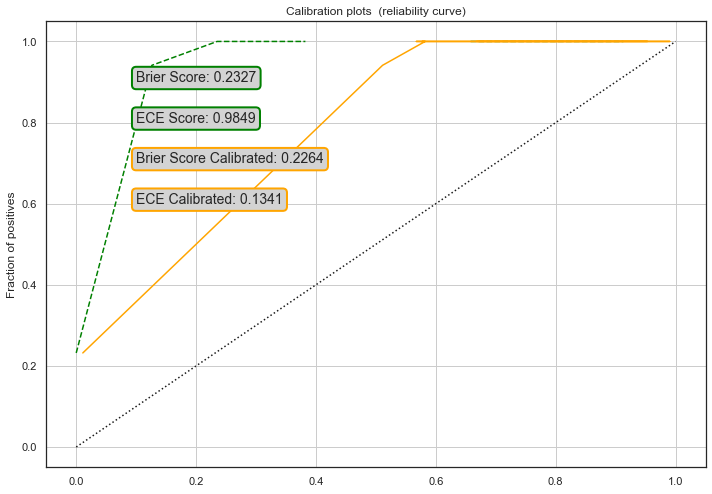

In [284]:
plot_compare_calibration(preds_proba_nn[:,1],
                         prob_nn_platt,
                         Y_validation,
                         num_bins=10)

In [285]:
## NN w/ Isotonic Regression
clf_nn_isotonic = CalibratedClassifierCV(ab, cv=2, method='isotonic')
clf_nn_isotonic.fit(X_train, Y_train)
prob_nn_isotonic = clf_nn_isotonic.predict_proba(X_validation)[:, 1]
prob_nn_isotonic

array([0.00268199, 0.00566857, 0.1702144 , ..., 0.11857375, 0.36642495,
       0.99392399])

In [286]:
calculate_mce(preds_proba_nn[:,1],Y_validation), calculate_mce(prob_nn_isotonic,Y_validation)

((0.8149008425439896,   bins        probas     label  count
  0    0  7.828647e-16  0.231972   6462
  1    1  1.262756e-01  0.941176     17
  2    2  2.350849e-01  1.000000      3
  3    3  3.823269e-01  1.000000      2
  4    4           NaN       NaN      0
  5    5           NaN       NaN      0
  6    6  6.580299e-01  1.000000     16
  7    7  7.825995e-01  1.000000      1
  8    8  8.735537e-01  1.000000      1
  9    9  9.127708e-01  1.000000     11),
 (0.09139821442846485,   bins    probas     label  count
  0    0  0.026577  0.027371   3142
  1    1  0.155742  0.162073    907
  2    2  0.271430  0.231884    276
  3    3  0.365042  0.353870    633
  4    4  0.441806  0.445230    566
  5    5  0.561510  0.609375     64
  6    6  0.642610  0.685897    312
  7    7  0.748439  0.674208    221
  8    8  0.866908  0.775510     49
  9    9  0.982623  0.979592    343))

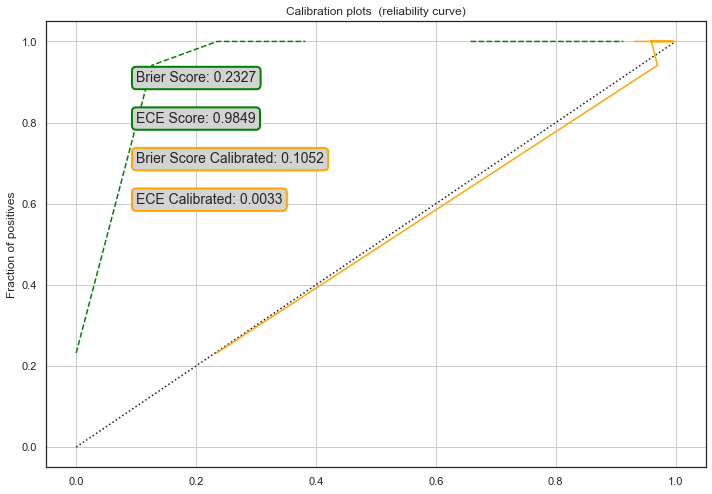

In [287]:
plot_compare_calibration(preds_proba_nn[:,1],
                         prob_nn_isotonic,
                         Y_validation,
                         num_bins=10)

### Sources
1. https://www.kaggle.com/ipbyrne/income-prediction-84-369-accuracym  
2. https://scikit-learn.org/stable/modules/calibration.html